In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import seaborn as sb
from IPython.display import clear_output

In [3]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common import results_plotter

In [4]:
lbr = "\n"

ObservationWrapper

In [5]:
class NoisedObservationWrapper(gym.Wrapper):
    # encapsulate environment with this wrapper and use env just like before:
    # env = NoisedObservationWrapper(gym.make("CartPole-v0"))
    # for PPO2:
    # from stable_baselines.common import make_vec_env
    # env = make_vec_env(NoisedObservationWrapper(gym.make("CartPole-v0")))

    def __init__(self, env, std_dev=0.3, mean=0, angle_min=10, angle_max=20, local_path="false"):
        super().__init__(env)
        self.env = env
        self.std_dev = std_dev
        self.mean = mean
        self.angle_min = np.radians(angle_min)
        self.angle_max = np.radians(angle_max)
        self.local_path = local_path
        
        if(self.local_path != "false"):
            log_file = open(self.local_path, "w")
            log_file.close()

    def step(self, action):
        # angle of pole is limited between radians [-0.418; 0.418]
        # which corresponds to [-24; 24] degrees
        observation, reward, done, info = self.env.step(action)
        
        angle = observation[2]
        
        noisy = (self.angle_min <= angle <= self.angle_max)

        # add noise if angle position is between angle_min and angle_max
        if (noisy):
            observation[2] += np.random.normal(self.mean, self.std_dev)

        if(self.local_path != "false"):
            log_file = open(self.local_path, "a")
            log_file.write(str((observation, reward, done, info, noisy)))
            log_file.write(lbr)
            log_file.close()      
            
        return observation, reward, done, info
    
    def step_noise(self, action):
        # angle of pole is limited between radians [-0.418; 0.418]
        # which corresponds to [-24; 24] degrees
        observation, reward, done, info = self.env.step(action)
        
        angle = observation[2]
        
        noisy = (self.angle_min <= angle <= self.angle_max)

        # add noise if angle position is between angle_min and angle_max
        if (noisy):
            observation[2] += np.random.normal(self.mean, self.std_dev)

        if(self.local_path != "false"):
            log_file = open(self.local_path, "a")
            log_file.write(str((observation, reward, done, info, noisy)))
            log_file.write(lbr)
            log_file.close()      
            
        return observation, reward, done, info, noisy

In [6]:
log_dir1 = "logs1"
log_dir2 = "logs2"
os.makedirs(log_dir1, exist_ok=True)
os.makedirs(log_dir2, exist_ok=True)

Environments

In [7]:
env1 = gym.make('CartPole-v1')
env1 = Monitor(env1, log_dir1) # required for using callback functions during training
env1 = DummyVecEnv([lambda: env1])
env1 = VecNormalize(env1, norm_obs=True, norm_reward=True) # State normalization

In [8]:
env2 = NoisedObservationWrapper(gym.make("CartPole-v0"))
env2 = Monitor(env2, log_dir2) # required for using callback functions during training
env2 = DummyVecEnv([lambda: env2])
env2 = VecNormalize(env2, norm_obs=True, norm_reward=True) # State normalization

Callback to save best training reward (from lecture)

In [10]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param avg_episodes: (int) average over the past n episodes (default: 100)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    :param vec_norm_env: (VecNormalize) stable-baselines VecNormalize object (contains Gym env)
    """
    def __init__(self, check_freq: int, log_dir: str, save_dir: str, verbose=1, avg_episodes=100, vec_norm_env=None):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(save_dir, 'best_model_nn')
        self.best_mean_reward = -np.inf
        self.best_timestep = -np.inf
        self.vec_norm_env = vec_norm_env
        self.avg_episodes = avg_episodes

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            
            if len(x) > 0:
                # Mean training reward over the last avg_episodes episodes
                mean_reward = np.mean(y[-self.avg_episodes:])

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    self.best_timestep = self.num_timesteps
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                    self.model.save(self.save_path)
                    if self.vec_norm_env is not None: 
                        self.vec_norm_env.save ("%s.env_normalizations" % self.save_path)

                if self.verbose > 0:
                    print("Num timesteps: {}".format(self.num_timesteps))
                    print("Best mean reward: {:.2f} (ts={}) - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, self.best_timestep, mean_reward))


        return True

Experiment settings

In [22]:
time_steps=30000
num_experiments = 5

Experiments without Uncertainty

In [23]:
tensorboard_dir1 = "cartpole1"
os.makedirs(tensorboard_dir1, exist_ok=True)
for e in range (1, (num_experiments+1), 1):
    log_dir = (log_dir1+ str(e))
    os.makedirs(log_dir, exist_ok=True)
    env1 = gym.make('CartPole-v1')
    env1 = Monitor(env1, log_dir) # required for using callback functions during training
    env1 = DummyVecEnv([lambda: env1])
    env1 = VecNormalize(env1, norm_obs=True, norm_reward=True) # State normalization
    model1 = PPO(MlpPolicy, env1, verbose=0)
    
    clear_output(wait=True)
    print("Run " +  str(e))
    
    eval_callback = EvalCallback(env1, best_model_save_path=log_dir,
                             log_path=log_dir, eval_freq=1000,
                             deterministic=True, render=False)
    
    model1.learn(total_timesteps=time_steps, callback=eval_callback)

    env1.close()
    
    

Run 5
Eval num_timesteps=1000, episode_reward=5.89 +/- 1.42
Episode length: 63.40 +/- 10.63
New best mean reward!
Eval num_timesteps=2000, episode_reward=4.93 +/- 0.68
Episode length: 58.40 +/- 7.91
Eval num_timesteps=3000, episode_reward=5.84 +/- 1.78
Episode length: 117.40 +/- 34.10
Eval num_timesteps=4000, episode_reward=7.58 +/- 1.91
Episode length: 162.00 +/- 39.65
New best mean reward!
Eval num_timesteps=5000, episode_reward=11.65 +/- 2.11
Episode length: 296.80 +/- 45.23
New best mean reward!
Eval num_timesteps=6000, episode_reward=11.75 +/- 3.62
Episode length: 338.80 +/- 109.52
New best mean reward!
Eval num_timesteps=7000, episode_reward=15.90 +/- 0.37
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=8000, episode_reward=15.21 +/- 0.10
Episode length: 500.00 +/- 0.00
Eval num_timesteps=9000, episode_reward=14.96 +/- 0.01
Episode length: 500.00 +/- 0.00
Eval num_timesteps=10000, episode_reward=14.98 +/- 0.02
Episode length: 500.00 +/- 0.00
Eval num_time

Experiment Results without Uncertainty

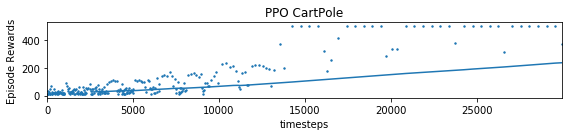

In [24]:
results_plotter.plot_results([log_dir1+str(1)], time_steps, results_plotter.X_TIMESTEPS, "PPO CartPole")
plt.savefig("results1-cartpole.png")
plt.show()

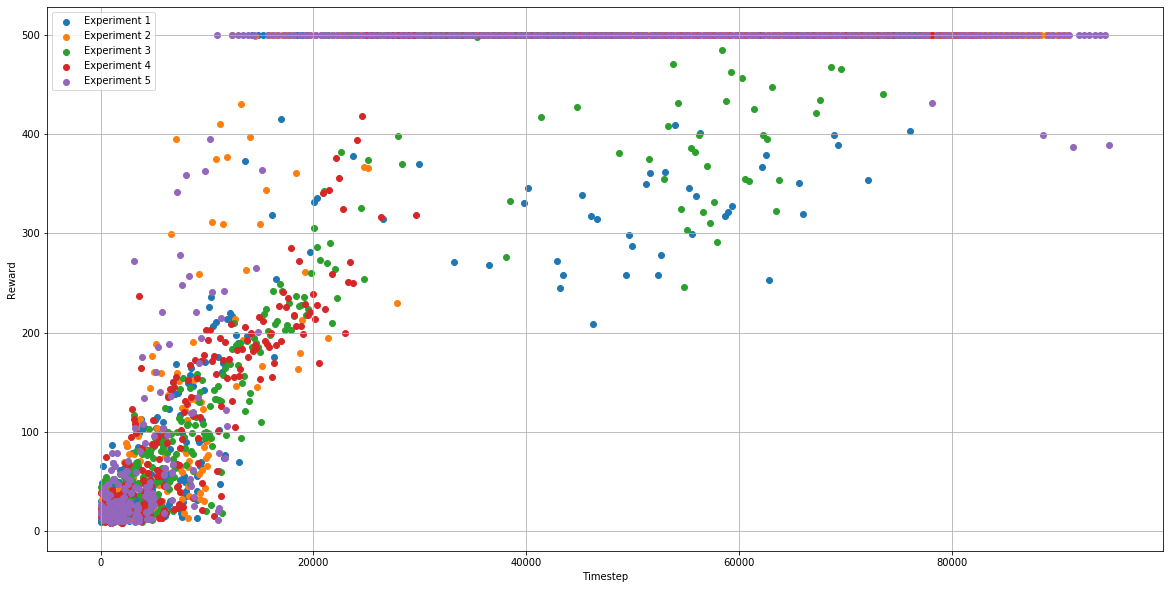

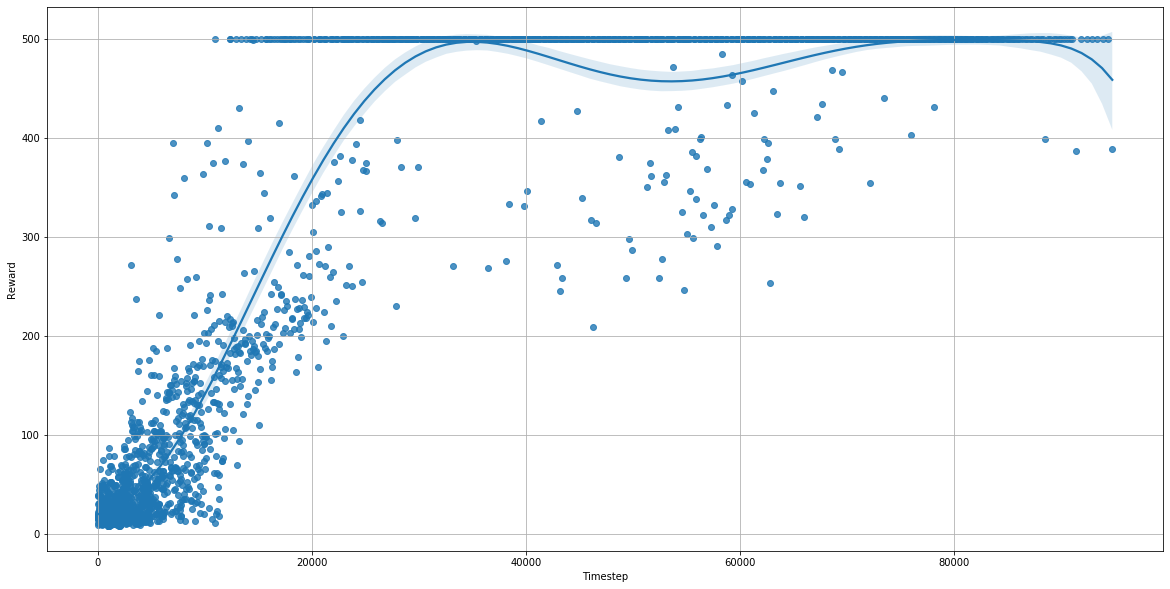

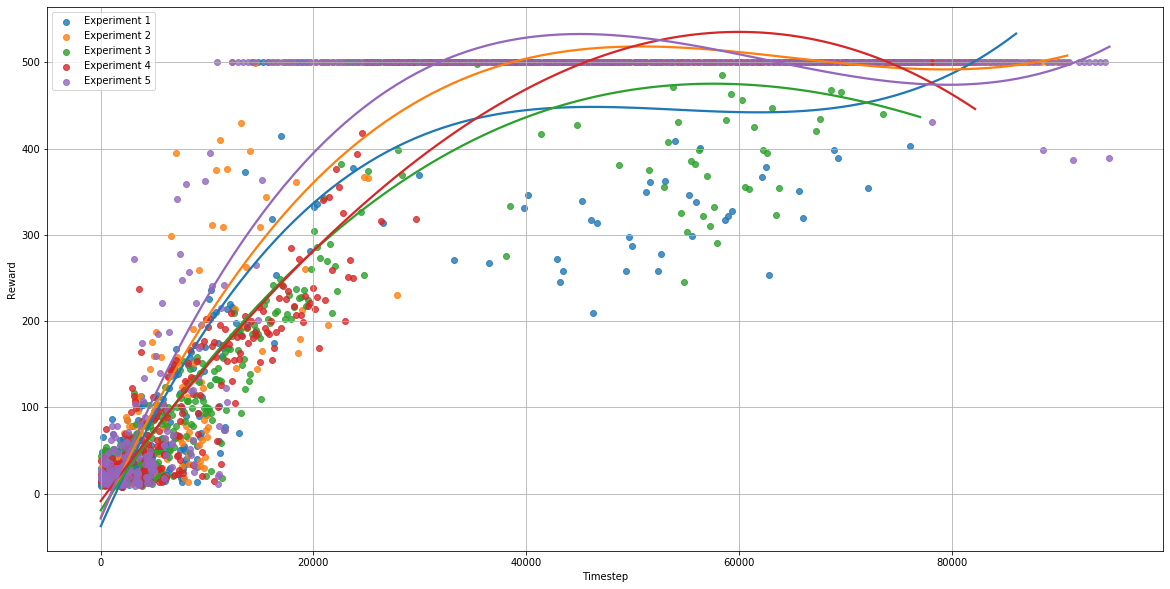

In [25]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

store = pd.DataFrame()
exps = []
for e in range (1, (num_experiments+1), 1):
    log_dir = (log_dir1+ str(e))
    x, y = ts2xy(load_results(log_dir), 'timesteps')
    plt.scatter(x=x, y=y, label="Experiment " + str(e))
    #plt.plot(x, y)
    d = {'x': x, 'y': y}
    exp = pd.DataFrame(d)
    exps.append(exp)
    store = store.append(exp, ignore_index=True)

plt.legend()
plt.ylabel("Reward")
plt.xlabel("Timestep")

#plt.plot(x_mean, y_mean)
#print(store)
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))
regplot=sb.regplot(x="x", y="y", data=store, fit_reg=True, scatter=True, order=8,truncate= True)
regplot.grid()
regplot.set_ylabel("Reward")
regplot.set_xlabel("Timestep")
plt.show()

fig, regplot2 = plt.subplots(figsize = (20,10))
i = 0
for exp in exps:
    i += 1
    sb.regplot(x="x", y="y", data=exp, fit_reg=True, scatter=True, order=3,truncate= True, ci=None, label="Experiment " + str(i))
regplot2.grid()
regplot2.legend()
regplot2.set_ylabel("Reward")
regplot2.set_xlabel("Timestep")
plt.show()

Experiments with Uncertainty

In [41]:
tensorboard_dir2 = "cartpole2"
os.makedirs(tensorboard_dir2, exist_ok=True)
for e in range (1, (num_experiments+1), 1):
    log_dir = (log_dir2 + str(e))
    os.makedirs(log_dir, exist_ok=True)
    env2 = NoisedObservationWrapper(gym.make("CartPole-v1"))
    env2 = Monitor(env2, log_dir) # required for using callback functions during training
    env2 = DummyVecEnv([lambda: env2])
    env2 = VecNormalize(env2, norm_obs=True, norm_reward=True)

    model2 = PPO(MlpPolicy, env2, verbose=0)
    callback2=SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir, save_dir = log_dir, avg_episodes=30, vec_norm_env=env2)
    model2.learn(total_timesteps=time_steps, callback=callback2)
    
    env2.close()

Saving new best model to logs21\best_model_nn
Num timesteps: 5000
Best mean reward: 45.90 (ts=5000) - Last mean reward per episode: 45.90
Saving new best model to logs21\best_model_nn
Num timesteps: 10000
Best mean reward: 124.23 (ts=10000) - Last mean reward per episode: 124.23
Saving new best model to logs21\best_model_nn
Num timesteps: 15000
Best mean reward: 198.37 (ts=15000) - Last mean reward per episode: 198.37
Saving new best model to logs21\best_model_nn
Num timesteps: 20000
Best mean reward: 255.77 (ts=20000) - Last mean reward per episode: 255.77
Saving new best model to logs21\best_model_nn
Num timesteps: 25000
Best mean reward: 341.03 (ts=25000) - Last mean reward per episode: 341.03
Saving new best model to logs21\best_model_nn
Num timesteps: 30000
Best mean reward: 425.40 (ts=30000) - Last mean reward per episode: 425.40
Saving new best model to logs22\best_model_nn
Num timesteps: 5000
Best mean reward: 48.37 (ts=5000) - Last mean reward per episode: 48.37
Saving new bes

Experiment Results with Uncertainty 

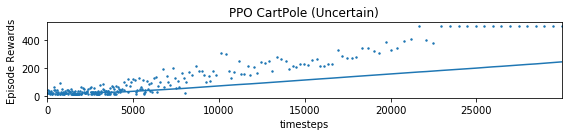

In [42]:
results_plotter.plot_results([log_dir2+str(1)], time_steps, results_plotter.X_TIMESTEPS, "PPO CartPole (Uncertain)")
plt.savefig("results2-cartpole.png")
plt.show()

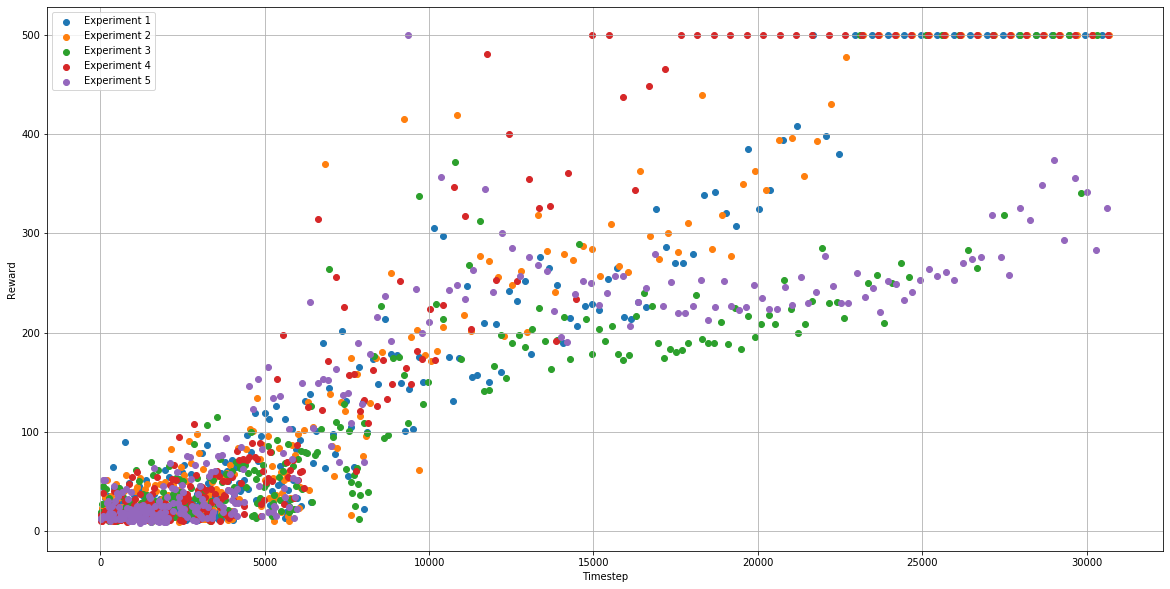

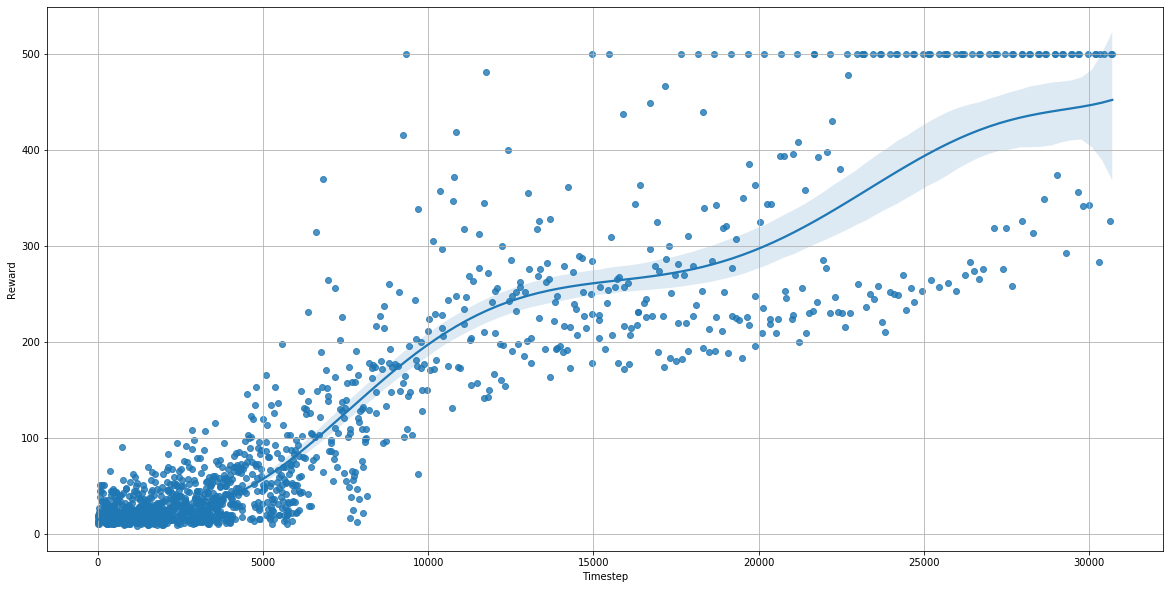

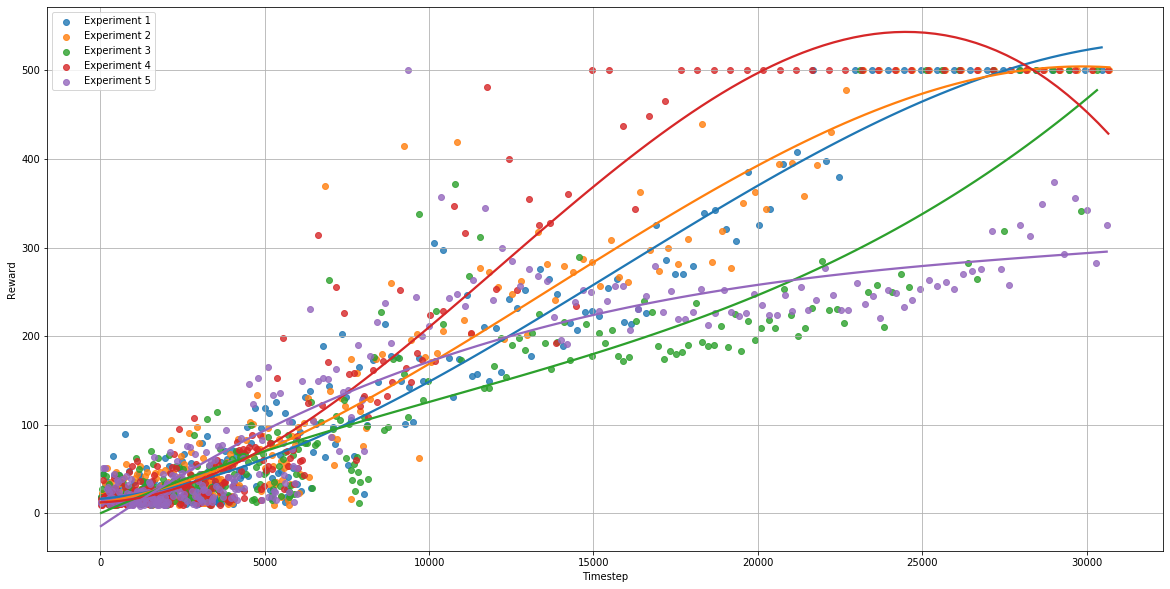

In [44]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

store = pd.DataFrame()
exps = []
for e in range (1, (num_experiments+1), 1):
    log_dir = (log_dir2+ str(e))
    x, y = ts2xy(load_results(log_dir), 'timesteps')
    plt.scatter(x=x, y=y, label = "Experiment " + str(e))
    #plt.plot(x, y)
    d = {'x': x, 'y': y}
    exp = pd.DataFrame(d)
    exps.append(exp)
    store = store.append(exp, ignore_index=True)

plt.legend()
plt.ylabel("Reward")
plt.xlabel("Timestep")
#plt.plot(x_mean, y_mean)
#print(store)
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))
fig.clf()
regplot=sb.regplot(x="x", y="y", data=store, fit_reg=True, scatter=True, order=8,truncate= True)
regplot.grid()
regplot.set_ylabel("Reward")
regplot.set_xlabel("Timestep")
plt.show()

fig, regplot2 = plt.subplots(figsize = (20,10))
i = 0
for exp in exps:
    i += 1
    sb.regplot(x="x", y="y", data=exp, fit_reg=True, scatter=True, order=3,truncate= True, ci=None, label = "Experiment " + str(i))
regplot2.grid()
regplot2.legend()
regplot2.set_ylabel("Reward")
regplot2.set_xlabel("Timestep")
plt.show()

In [ ]:
Evaluation of best model

In [ ]:
model = PPO.load("%s/best_model_nn.zip" % (log_dir1+str(1)))
env = NoisedObservationWrapper(gym.make("CartPole-v1"), local_path="test.txt")
env = Monitor(env, log_dir2) # required for using callback functions during training

env.training=False

expCounter1 = []

exp = 1
while exp <= 1000:
    state = env.reset()
    done=False
    cumReward = 0
    steps=0
    noise = 0
    
    while not done: 
        steps += 1
        action, _states = model.predict(state)
        state, reward, done, _, noisy = env.step_noise(action)
        cumReward += reward
        
        if noisy:
            noise += 1

    env.close()
    
    expCounter1.append([steps, cumReward, noise])
    
    clear_output(wait=True)
    print("Experiment " +  str(exp) + " Reward: " + str(cumReward))
    exp+= 1

results1 = np.mat(expCounter1)
#print(results)

stepCounter1 = np.array(results1[:,0])
noiseCounter1 = np.array(results1[:,2])
avgNoise1 = np.divide(noiseCounter1,stepCounter1)
#print(stepCounter)
#print(noiseCounter)
#print(avgNoise)
clear_output(wait=True)
print ("avg step count=%.3f" % (np.mean(expCounter1[:][1])))
print ("avg noise count=%.3f" % (np.mean(noiseCounter1)))
print ("avg noise per length=%.3f" % (np.mean(np.divide(noiseCounter1,stepCounter1))))

In [ ]:
model = PPO.load("%s/best_model_nn.zip" % (log_dir2 + str(1)))
env = NoisedObservationWrapper(gym.make("CartPole-v1"), local_path="test.txt")
env = Monitor(env, log_dir2) # required for using callback functions during training

env.training=False

expCounter2 = []

exp = 1
while exp <= 1000:
    state = env.reset()
    done=False
    cumReward = 0
    steps=0
    noise = 0
    
    while not done: 
        steps += 1
        action, _states = model.predict(state)
        state, reward, done, _, noisy = env.step_noise(action)
        cumReward += reward
        
        if noisy:
            noise += 1

    env.close()
    
    expCounter2.append([steps, cumReward, noise])
    
    clear_output(wait=True)
    print("Experiment " +  str(exp) + " Reward: " + str(cumReward))
 #   print ("steps=%d, cumReward=%.3f" % (steps, cumReward))
    exp+= 1

results2 = np.mat(expCounter2)
#print(results)

stepCounter2 = np.array(results2[:,0])
noiseCounter2 = np.array(results2[:,2])
avgNoise2 = np.divide(noiseCounter2,stepCounter2)
clear_output(wait=True)
print ("avg step count=%.3f" % (np.mean(expCounter2[:][1])))
print ("avg noise count=%.3f" % (np.mean(noiseCounter2)))
print ("avg noise per length=%.3f" % (np.mean(np.divide(noiseCounter2,stepCounter2))))

In [ ]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()


boxplot_data = {'PPO':np.reshape(stepCounter1,newshape=-1), 'PPO (uncertain)':np.reshape(stepCounter2,newshape=-1)}

plt.boxplot(boxplot_data.values(), labels = boxplot_data.keys())

plt.ylabel("Experiment Length")

plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()


boxplot_data = {'PPO':np.reshape(np.divide(noiseCounter1,stepCounter1),newshape=-1), 'PPO (uncertain)':np.reshape(np.divide(noiseCounter2,stepCounter2),newshape=-1)}

plt.boxplot(boxplot_data.values(), labels = boxplot_data.keys())

plt.ylabel("Noise / Experiment Length")

plt.show()

In [ ]:
np.concatenate((stepCounter2,avgNoise2), axis=1)

In [ ]:
fig, regplot = plt.subplots(figsize = (20,10))
sb.regplot(x=np.reshape(stepCounter1,-1), y=np.reshape(avgNoise1,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO")
sb.regplot(x=np.reshape(stepCounter2,-1), y=np.reshape(avgNoise2,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO (uncertain)")
regplot.legend()
regplot.set_ylabel("Average Noise")
regplot.set_xlabel("Experiment Length")
regplot.grid()
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))
sb.regplot(x=np.reshape(stepCounter1,-1), y=np.reshape(noiseCounter1,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO")
sb.regplot(x=np.reshape(stepCounter2,-1), y=np.reshape(noiseCounter2,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO (uncertain)")
#regplot.set_xlim(0, 1) # limit y axis
regplot.set_ylabel("Noise")
regplot.set_xlabel("Experiment Length")
regplot.legend()
regplot.grid()
plt.show()

In [ ]:
log_file = open("test.txt", 'r')
for log_line in log_file:
    print(log_line)
log_file.close()